In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    'strat-binary': [0, 1],
    '4type': [0, 1, 2, 3],
    '5type': [0, 1, 2, 3, 4],
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [11]:
def task_eval(task):
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)


Task: Binary


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 1.5473229436602666e-266
Post-hoc Dunn test array:


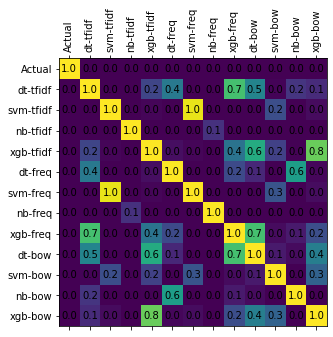

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.718037  0.674419    0.696228  0.550820
xgb-bow    0.699772  0.651163    0.675467  0.727869
svm-freq   0.810502  0.517442    0.663972  0.728689
xgb-tfidf  0.707763  0.610465    0.659114  0.639344
svm-tfidf  0.824201  0.485465    0.654833  0.655738
nb-bow     0.606164  0.683140    0.644652  0.705738
xgb-freq   0.688356  0.598837    0.643597  0.663115
dt-bow     0.713470  0.561047    0.637258  0.680328
dt-tfidf   0.691781  0.563953    0.627867  0.522131
dt-freq    0.674658  0.549419    0.612038  0.670492
nb-tfidf   0.500000  0.680233    0.590116  0.627869
nb-freq    0.450913  0.703488    0.577201  0.686066

Mean: 0.667872546376847




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


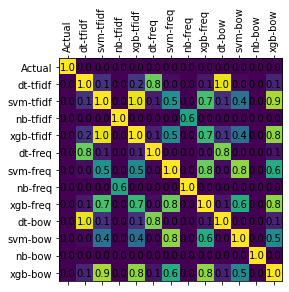

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.800228  0.540698    0.670463  0.709016
xgb-bow    0.778539  0.546512    0.662525  0.717213
svm-freq   0.810502  0.500000    0.655251  0.681148
xgb-freq   0.807078  0.488372    0.647725  0.709836
svm-tfidf  0.791096  0.502907    0.647001  0.722951
xgb-tfidf  0.803653  0.468023    0.635838  0.427049
dt-bow     0.740868  0.526163    0.633515  0.680328
dt-tfidf   0.795662  0.389535    0.592598  0.675410
dt-freq    0.788813  0.386628    0.587720  0.416393
nb-bow     0.458904  0.625000    0.541952  0.727049
nb-tfidf   0.283105  0.793605    0.538355  0.505738
nb-freq    0.275114  0.776163    0.525638  0.713115

Mean: 0.6414294728845541




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


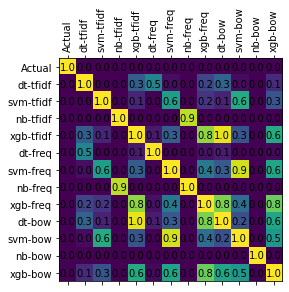

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.775114  0.595930    0.685522  0.722951
xgb-bow    0.768265  0.569767    0.669016  0.706557
svm-tfidf  0.829909  0.491279    0.660594  0.681967
svm-freq   0.809361  0.502907    0.656134  0.734426
dt-bow     0.771689  0.523256    0.647473  0.436066
xgb-freq   0.792237  0.488372    0.640305  0.433607
xgb-tfidf  0.788813  0.482558    0.635685  0.702459
nb-bow     0.526256  0.694767    0.610512  0.724590
dt-tfidf   0.783105  0.424419    0.603762  0.667213
dt-freq    0.763699  0.421512    0.592605  0.701639
nb-tfidf   0.293379  0.790698    0.542038  0.712295
nb-freq    0.300228  0.781977    0.541103  0.573770

Mean: 0.6526729482686794




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


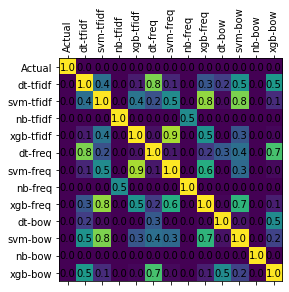

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.753425  0.566860    0.660143  0.663934
svm-bow    0.715753  0.595930    0.655842  0.412295
svm-tfidf  0.732877  0.569767    0.651322  0.700820
xgb-tfidf  0.786530  0.494186    0.640358  0.668852
xgb-bow    0.688356  0.575581    0.631969  0.690984
xgb-freq   0.768265  0.494186    0.631225  0.704098
dt-bow     0.666667  0.581395    0.624031  0.642623
dt-tfidf   0.777397  0.392442    0.584920  0.686885
dt-freq    0.773973  0.383721    0.578847  0.426230
nb-bow     0.454338  0.645349    0.549843  0.681967
nb-tfidf   0.277397  0.805233    0.541315  0.508197
nb-freq    0.263699  0.790698    0.527198  0.656557

Mean: 0.6366932552421563




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


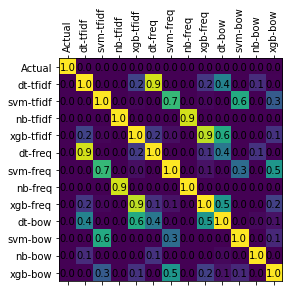

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.869863  0.433140    0.651501  0.718852
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
dt-bow     0.816210  0.436047    0.626128  0.709016
xgb-freq   0.858447  0.372093    0.615270  0.759016
svm-freq   0.949772  0.273256    0.611514  0.694262
xgb-tfidf  0.859589  0.360465    0.610027  0.692623
dt-freq    0.823059  0.360465    0.591762  0.721311
dt-tfidf   0.827626  0.354651    0.591138  0.472951
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.746721

Mean: 0.6426368841947052




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


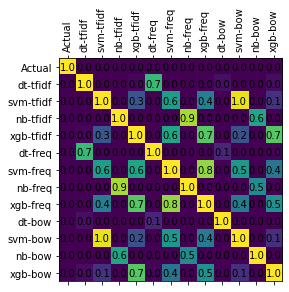

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.785388  0.572674    0.679031  0.645082
xgb-bow    0.727169  0.616279    0.671724  0.713115
svm-tfidf  0.812785  0.500000    0.656393  0.724590
xgb-freq   0.794521  0.491279    0.642900  0.459836
xgb-tfidf  0.787671  0.485465    0.636568  0.702459
svm-freq   0.821918  0.436047    0.628982  0.653279
dt-tfidf   0.716895  0.491279    0.604087  0.709016
dt-freq    0.723744  0.444767    0.584256  0.456557
dt-bow     0.651826  0.514535    0.583181  0.613115
nb-tfidf   0.309361  0.843023    0.576192  0.470492
nb-freq    0.304795  0.843023    0.573909  0.695902
nb-bow     0.345890  0.787791    0.566841  0.725410

Mean: 0.6464663946545119




Overall scores:
Friedman Chi Square Statistic: 28.19047619047621. p-value: 3.3407157825333525e-05.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.000000

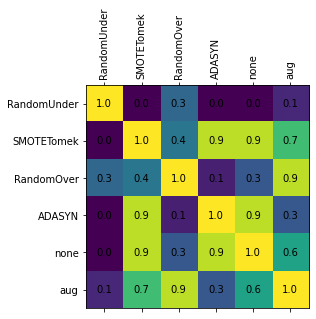

In [12]:
task_eval('binary')


Task: Strat-Binary


Method: RandomUnder

Task: strat-binary.
Cochran's Q test p-value: 1.770260898686121e-109
Post-hoc Dunn test array:


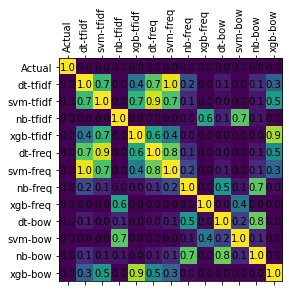

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.670091  0.473837    0.571964  0.613115
dt-tfidf   0.664384  0.459302    0.561843  0.607377
nb-bow     0.597032  0.523256    0.560144  0.527049
xgb-bow    0.719178  0.392442    0.555810  0.623770
dt-bow     0.594749  0.508721    0.551735  0.570492
nb-freq    0.638128  0.441860    0.539994  0.582787
nb-tfidf   0.539954  0.531977    0.535966  0.627049
dt-freq    0.719178  0.343023    0.531101  0.537705
svm-bow    0.578767  0.456395    0.517581  0.544262
svm-freq   0.745434  0.255814    0.500624  0.614754
xgb-freq   0.577626  0.398256    0.487941  0.576230
xgb-tfidf  0.800228  0.174419    0.487323  0.606557

Mean: 0.569386584001111




Method: SMOTETomek

Task: strat-binary.
Cochran's Q test p-value: 1.8449832247252725e-239
Post-hoc Dunn test array:


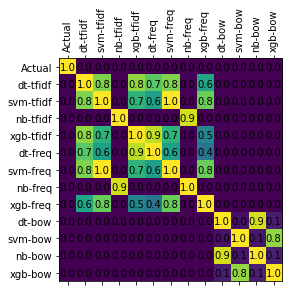

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.775114  0.421512    0.598313  0.675410
svm-freq   0.785388  0.395349    0.590368  0.663934
xgb-freq   0.849315  0.252907    0.551111  0.670492
dt-tfidf   0.841324  0.235465    0.538395  0.453279
dt-freq    0.832192  0.235465    0.533828  0.666393
xgb-tfidf  0.842466  0.218023    0.530245  0.675410
nb-freq    0.377854  0.651163    0.514508  0.604098
xgb-bow    0.720320  0.308140    0.514230  0.681148
nb-tfidf   0.382420  0.633721    0.508071  0.570492
svm-bow    0.739726  0.273256    0.506491  0.454918
nb-bow     0.660959  0.340116    0.500538  0.608197
dt-bow     0.672374  0.305233    0.488803  0.568852

Mean: 0.5673000343078394




Method: RandomOver

Task: strat-binary.
Cochran's Q test p-value: 1.5654919629232624e-282
Post-hoc Dunn test array:


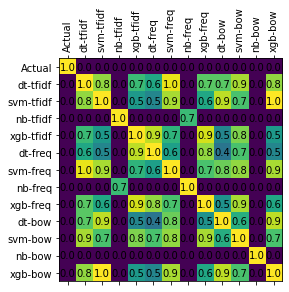

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.727169  0.456395    0.591782  0.648361
svm-freq   0.751142  0.406977    0.579059  0.661475
svm-bow    0.776256  0.357558    0.566907  0.654098
dt-bow     0.763699  0.354651    0.559175  0.431148
xgb-bow    0.777397  0.328488    0.552943  0.665574
dt-freq    0.819635  0.273256    0.546445  0.422951
dt-tfidf   0.803653  0.276163    0.539908  0.663115
xgb-freq   0.823059  0.250000    0.536530  0.650820
xgb-tfidf  0.829909  0.238372    0.534140  0.654918
nb-bow     0.463470  0.572674    0.518072  0.658197
nb-freq    0.324201  0.703488    0.513845  0.494262
nb-tfidf   0.316210  0.694767    0.505489  0.650820

Mean: 0.5803303763243234




Method: ADASYN

Task: strat-binary.
Cochran's Q test p-value: 4.318916927770725e-295
Post-hoc Dunn test array:


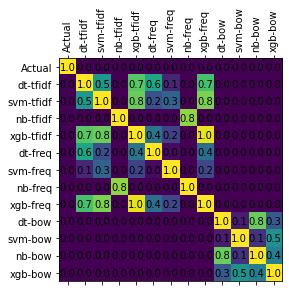

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.923516  0.244186    0.583851  0.459836
svm-tfidf  0.915525  0.194767    0.555146  0.706557
dt-tfidf   0.909817  0.165698    0.537758  0.689344
dt-freq    0.893836  0.168605    0.531220  0.731967
xgb-freq   0.949772  0.090116    0.519944  0.712295
xgb-tfidf  0.952055  0.081395    0.516725  0.700000
nb-freq    0.417808  0.581395    0.499602  0.600000
nb-bow     0.735160  0.255814    0.495487  0.628689
nb-tfidf   0.415525  0.572674    0.494100  0.615574
xgb-bow    0.793379  0.162791    0.478085  0.707377
dt-bow     0.746575  0.206395    0.476485  0.594262
svm-bow    0.826484  0.125000    0.475742  0.463934

Mean: 0.5510880486191094




Method: none

Task: strat-binary.
Cochran's Q test p-value: 4.308280677209079e-290
Post-hoc Dunn test array:


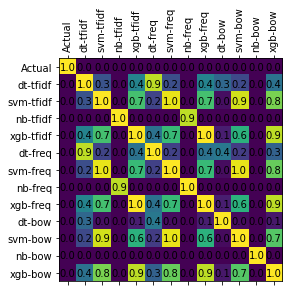

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
nb-freq    0.478311  0.665698    0.572004  0.711475
nb-tfidf   0.485160  0.656977    0.571068  0.595082
nb-bow     0.650685  0.453488    0.552087  0.718033
dt-tfidf   0.908676  0.148256    0.528466  0.531148
dt-freq    0.904110  0.151163    0.527636  0.709016
xgb-bow    0.965753  0.063953    0.514853  0.709016
xgb-tfidf  0.962329  0.063953    0.513141  0.691803
xgb-freq   0.962329  0.063953    0.513141  0.717213
dt-bow     0.893836  0.119186    0.506511  0.675410
svm-freq   0.997717  0.002907    0.500312  0.716393
svm-bow    1.000000  0.000000    0.500000  0.694262
svm-tfidf  0.996575  0.002907    0.499741  0.533607

Mean: 0.5614585120199966




Method: aug

Task: strat-binary.
Cochran's Q test p-value: 3.6119617030299816e-183
Post-hoc Dunn test array:


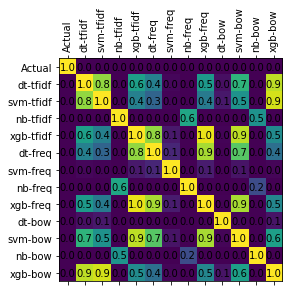

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-bow    0.694064  0.500000    0.597032  0.654098
svm-tfidf  0.698630  0.482558    0.590594  0.525410
svm-bow    0.740868  0.421512    0.581190  0.657377
xgb-tfidf  0.746575  0.415698    0.581137  0.653279
dt-bow     0.627854  0.531977    0.579915  0.600820
dt-tfidf   0.728311  0.421512    0.574911  0.689344
svm-freq   0.837900  0.311047    0.574473  0.641803
dt-freq    0.767123  0.377907    0.572515  0.637705
xgb-freq   0.767123  0.366279    0.566701  0.514754
nb-freq    0.507991  0.569767    0.538879  0.501639
nb-tfidf   0.522831  0.494186    0.508509  0.650820
nb-bow     0.496575  0.514535    0.505555  0.639344

Mean: 0.5978008266555574




Overall scores:
Friedman Chi Square Statistic: 18.571428571428598. p-value: 0.002309269634406294.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.000000 

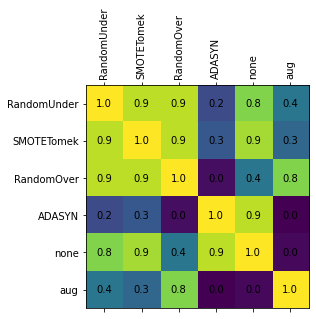

In [13]:
task_eval('strat-binary')


Task: 5Type


Method: RandomUnder

Task: 5type.
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


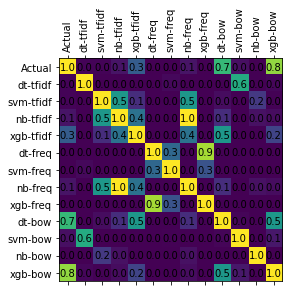

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-tfidf  0.327626  0.252941    0.375  0.261905  0.282258    0.299946   
dt-bow     0.336758  0.364706    0.250  0.380952  0.153226    0.297128   
dt-freq    0.503425  0.382353    0.125  0.261905  0.201613    0.294859   
svm-bow    0.391553  0.370588    0.000  0.500000  0.209677    0.294364   
dt-tfidf   0.428082  0.258824    0.125  0.214286  0.290323    0.263303   
nb-bow     0.242009  0.376471    0.250  0.285714  0.161290    0.263097   
svm-freq   0.501142  0.264706    0.000  0.333333  0.177419    0.255320   
xgb-freq   0.545662  0.200000    0.125  0.166667  0.217742    0.251014   
nb-freq    0.275114  0.458824    0.000  0.309524  0.209677    0.250628   
xgb-bow    0.359589  0.329412    0.000  0.166667  0.250000    0.221133   
nb-tfidf   0.305936  0.294118    0.000  0.238095  0.241935    0.216017   
svm-tfidf  0.303653  0.217647    0.000

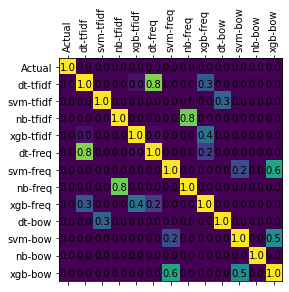

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
svm-freq   0.525114  0.476471    0.000  0.309524  0.217742    0.305770   
xgb-tfidf  0.752283  0.323529    0.000  0.238095  0.201613    0.303104   
svm-tfidf  0.424658  0.423529    0.000  0.404762  0.225806    0.295751   
xgb-bow    0.547945  0.441176    0.000  0.238095  0.233871    0.292218   
dt-bow     0.454338  0.429412    0.000  0.285714  0.250000    0.283893   
xgb-freq   0.732877  0.341176    0.000  0.190476  0.153226    0.283551   
svm-bow    0.579909  0.405882    0.000  0.142857  0.225806    0.270891   
dt-tfidf   0.713470  0.270588    0.000  0.190476  0.169355    0.268778   
dt-freq    0.711187  0.294118    0.000  0.166667  0.112903    0.256975   
nb-tfidf   0.141553  0.311765    0.250  0.380952  0.193548    0.255564   
nb-bow     0.307078  0.311765    0.125  0.285714  0.201613    0.246234   
nb-freq    0.142694  0.276471    0.250

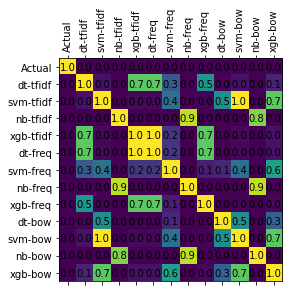

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-bow    0.622146  0.394118    0.375  0.309524  0.153226    0.370803   
svm-freq   0.615297  0.476471    0.000  0.404762  0.193548    0.338016   
svm-tfidf  0.606164  0.376471    0.000  0.500000  0.185484    0.333624   
dt-bow     0.601598  0.358824    0.250  0.261905  0.169355    0.328336   
svm-bow    0.623288  0.364706    0.250  0.238095  0.153226    0.325863   
nb-bow     0.099315  0.305882    0.375  0.547619  0.217742    0.309112   
dt-freq    0.698630  0.311765    0.000  0.119048  0.209677    0.267824   
xgb-tfidf  0.698630  0.347059    0.000  0.119048  0.161290    0.265205   
xgb-freq   0.700913  0.364706    0.000  0.047619  0.209677    0.264583   
dt-tfidf   0.691781  0.317647    0.000  0.119048  0.185484    0.262792   
nb-tfidf   0.116438  0.341176    0.250  0.428571  0.145161    0.256270   
nb-freq    0.118721  0.270588    0.250

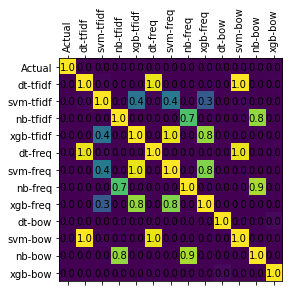

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.089041  0.311765    0.125  0.785714  0.266129    0.315530   
svm-freq   0.924658  0.188235    0.250  0.000000  0.000000    0.272579   
svm-tfidf  0.899543  0.158824    0.250  0.000000  0.048387    0.271351   
nb-tfidf   0.117580  0.347059    0.250  0.404762  0.177419    0.259364   
nb-freq    0.115297  0.294118    0.250  0.428571  0.185484    0.254694   
xgb-freq   0.902968  0.294118    0.000  0.000000  0.072581    0.253933   
xgb-tfidf  0.901826  0.276471    0.000  0.000000  0.064516    0.248563   
dt-tfidf   0.808219  0.247059    0.000  0.023810  0.096774    0.235172   
svm-bow    0.803653  0.335294    0.000  0.000000  0.016129    0.231015   
dt-freq    0.812785  0.223529    0.000  0.023810  0.088710    0.229767   
xgb-bow    0.731735  0.276471    0.000  0.071429  0.040323    0.223991   
dt-bow     0.665525  0.264706    0.000

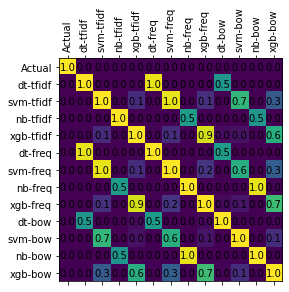

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.090183  0.305882    0.375  0.547619  0.241935    0.312124   
xgb-bow    0.897260  0.400000    0.000  0.071429  0.048387    0.283415   
dt-bow     0.818493  0.382353    0.000  0.142857  0.064516    0.281644   
svm-bow    0.942922  0.435294    0.000  0.000000  0.008065    0.277256   
svm-tfidf  0.948630  0.317647    0.000  0.000000  0.040323    0.261320   
nb-tfidf   0.118721  0.352941    0.250  0.404762  0.161290    0.257543   
xgb-freq   0.905251  0.288235    0.000  0.000000  0.088710    0.256439   
xgb-tfidf  0.904110  0.282353    0.000  0.000000  0.088710    0.255034   
nb-freq    0.115297  0.270588    0.250  0.428571  0.169355    0.246762   
svm-freq   0.962329  0.270588    0.000  0.000000  0.000000    0.246583   
dt-tfidf   0.820776  0.264706    0.000  0.023810  0.120968    0.246052   
dt-freq    0.824201  0.252941    0.000

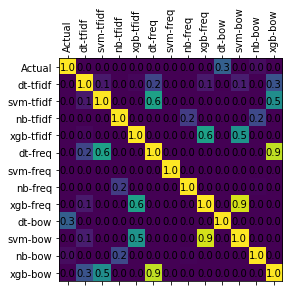

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
dt-freq    0.460046  0.370588    0.500  0.404762  0.274194    0.401918   
dt-bow     0.367580  0.341176    0.500  0.452381  0.298387    0.391905   
xgb-freq   0.536530  0.405882    0.250  0.404762  0.314516    0.382338   
svm-bow    0.512557  0.500000    0.125  0.333333  0.370968    0.368372   
dt-tfidf   0.500000  0.364706    0.375  0.309524  0.290323    0.367910   
nb-bow     0.262557  0.370588    0.375  0.357143  0.411290    0.355316   
xgb-tfidf  0.567352  0.317647    0.125  0.404762  0.338710    0.350694   
svm-freq   0.644977  0.400000    0.000  0.309524  0.314516    0.333803   
xgb-bow    0.456621  0.382353    0.125  0.357143  0.346774    0.333578   
svm-tfidf  0.460046  0.288235    0.125  0.452381  0.282258    0.321584   
nb-tfidf   0.251142  0.370588    0.125  0.452381  0.233871    0.286596   
nb-freq    0.231735  0.311765    0.250

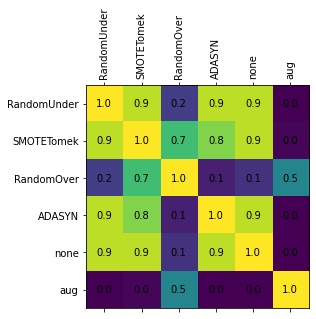

In [14]:
task_eval('5type')


Task: 4Type


Method: RandomUnder

Task: 4type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


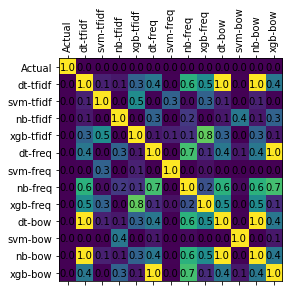

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.594118    0.375  0.564103  0.170732    0.425988  0.329412
xgb-bow    0.452941    0.250  0.564103  0.178862    0.361476  0.400000
dt-freq    0.447059    0.375  0.384615  0.235772    0.360612  0.291176
xgb-freq   0.311765    0.375  0.512821  0.219512    0.354774  0.329412
dt-bow     0.435294    0.375  0.461538  0.138211    0.352511  0.226471
dt-tfidf   0.358824    0.250  0.564103  0.219512    0.348110  0.347059
nb-tfidf   0.470588    0.125  0.487179  0.292683    0.343863  0.264706
xgb-tfidf  0.241176    0.375  0.410256  0.317073    0.335877  0.361765
svm-tfidf  0.270588    0.250  0.615385  0.146341    0.320579  0.432353
nb-bow     0.329412    0.125  0.538462  0.276423    0.317324  0.302941
nb-freq    0.441176    0.125  0.307692  0.243902    0.279443  0.361765
svm-freq   0.258824    0.250  0.435897  0.113821    0.264636  0.329412

Mean:

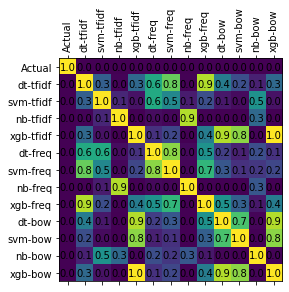

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.505882    0.500  0.615385  0.130081    0.437837  0.382353
dt-bow     0.588235    0.125  0.615385  0.317073    0.411423  0.408824
xgb-bow    0.576471    0.125  0.487179  0.390244    0.394723  0.429412
svm-tfidf  0.488235    0.125  0.743590  0.211382    0.392052  0.488235
svm-bow    0.611765    0.125  0.435897  0.382114    0.388694  0.450000
svm-freq   0.558824    0.000  0.666667  0.227642    0.363283  0.338235
xgb-tfidf  0.576471    0.000  0.461538  0.406504    0.361128  0.488235
dt-tfidf   0.564706    0.000  0.487179  0.308943    0.340207  0.438235
xgb-freq   0.582353    0.000  0.410256  0.325203    0.329453  0.344118
dt-freq    0.552941    0.000  0.487179  0.268293    0.327103  0.455882
nb-freq    0.511765    0.375  0.307692  0.105691    0.325037  0.497059
nb-tfidf   0.523529    0.375  0.256410  0.121951    0.319223  0.482353

Mean:

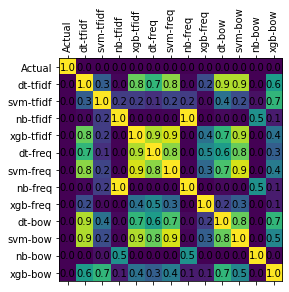

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.535294    0.250  0.589744  0.243902    0.404735  0.444118
svm-freq   0.523529    0.000  0.769231  0.260163    0.388231  0.341176
svm-bow    0.582353    0.125  0.615385  0.211382    0.383530  0.435294
svm-tfidf  0.452941    0.000  0.846154  0.195122    0.373554  0.314706
xgb-bow    0.517647    0.125  0.589744  0.227642    0.365008  0.429412
xgb-freq   0.576471    0.000  0.435897  0.398374    0.352686  0.394118
nb-bow     0.441176    0.500  0.307692  0.130081    0.344738  0.411765
dt-freq    0.535294    0.000  0.410256  0.382114    0.331916  0.452941
nb-freq    0.511765    0.375  0.307692  0.113821    0.327070  0.441176
nb-tfidf   0.517647    0.375  0.282051  0.113821    0.322130  0.482353
xgb-tfidf  0.541176    0.000  0.333333  0.382114    0.314156  0.341176
dt-tfidf   0.535294    0.000  0.333333  0.357724    0.306588  0.447059

Mean:

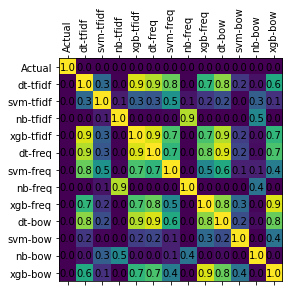

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.482353
xgb-bow    0.652941    0.125  0.282051  0.333333    0.348331  0.352941
dt-bow     0.670588    0.125  0.256410  0.284553    0.334138  0.423529
nb-tfidf   0.529412    0.375  0.307692  0.121951    0.333514  0.382353
nb-freq    0.535294    0.375  0.307692  0.097561    0.328887  0.517647
svm-bow    0.735294    0.125  0.025641  0.398374    0.321077  0.461765
xgb-freq   0.647059    0.000  0.230769  0.357724    0.308888  0.450000
dt-freq    0.641176    0.000  0.230769  0.333333    0.301320  0.479412
xgb-tfidf  0.641176    0.000  0.205128  0.333333    0.294910  0.347059
dt-tfidf   0.647059    0.000  0.205128  0.317073    0.292315  0.464706
svm-freq   0.647059    0.000  0.000000  0.349593    0.249163  0.467647
svm-tfidf  0.564706    0.000  0.000000  0.390244    0.238737  0.470588

Mean:

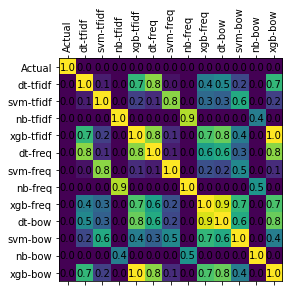

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.723529    0.000  0.358974  0.308943    0.347862  0.502941
nb-bow     0.458824    0.500  0.307692  0.105691    0.343052  0.502941
xgb-freq   0.705882    0.000  0.256410  0.373984    0.334069  0.564706
xgb-bow    0.676471    0.000  0.282051  0.365854    0.331094  0.514706
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.314706
nb-freq    0.523529    0.375  0.307692  0.097561    0.325946  0.535294
xgb-tfidf  0.700000    0.000  0.230769  0.349593    0.320091  0.341176
svm-freq   0.829412    0.000  0.000000  0.414634    0.311011  0.485294
dt-freq    0.705882    0.000  0.205128  0.325203    0.309053  0.494118
dt-tfidf   0.688235    0.000  0.230769  0.317073    0.309019  0.517647
svm-tfidf  0.800000    0.000  0.000000  0.430894    0.307724  0.555882
svm-bow    0.758824    0.000  0.025641  0.422764    0.301807  0.347059

Mean:

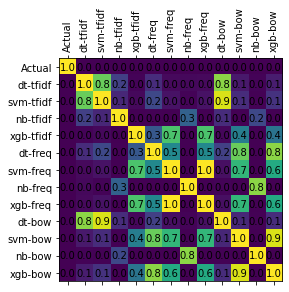

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.658824    0.500  0.512821  0.479675    0.537830  0.479412
dt-freq    0.547059    0.500  0.589744  0.487805    0.531152  0.373529
dt-bow     0.441176    0.500  0.615385  0.479675    0.509059  0.476471
dt-tfidf   0.511765    0.500  0.615385  0.357724    0.496218  0.558824
xgb-freq   0.629412    0.250  0.487179  0.504065    0.467664  0.414706
xgb-bow    0.588235    0.250  0.410256  0.528455    0.444237  0.529412
svm-freq   0.729412    0.000  0.615385  0.341463    0.421565  0.467647
svm-bow    0.629412    0.125  0.384615  0.495935    0.408741  0.573529
svm-tfidf  0.558824    0.000  0.538462  0.382114    0.369850  0.558824
nb-tfidf   0.417647    0.125  0.410256  0.430894    0.345949  0.541176
nb-freq    0.394118    0.125  0.538462  0.308943    0.341631  0.364706
nb-bow     0.294118    0.125  0.410256  0.463415    0.323197  0.538235

Mean:

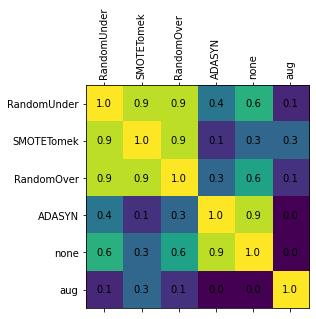

In [15]:
task_eval('4type')

In [16]:
def compare_aug(method):
    for task in ['binary', 'strat-binary', '5type', '4type']:
        df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
        aug_df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-aug.csv')
        df['Common'] = df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        aug_df['Common'] = aug_df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        result = cochrans_q([df['Common'], aug_df['Common']])
        
        #get row with int correct/incorrect
        aug_columns = list(aug_df.columns.values)
        common, actual = aug_columns.index('Common'), aug_columns.index('Actual')
        aug_df["Correct"] = aug_df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        columns = list(df.columns.values)
        common, actual = columns.index('Common'), columns.index('Actual')
        df["Correct"] = df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        
        print(f'Task: {task}')
        print(f"McNemar's test p-value: {result.pvalue}\n")
        print(f'Augmented mean accuracy: {aug_df["Correct"].mean()}.\nOriginal mean accuracy: {df["Correct"].mean()}.')
        print('\n')

In [17]:
compare_aug('RandomUnder')

Task: binary
McNemar's test p-value: 8.518170689131773e-28

Augmented mean accuracy: 0.7377049180327869.
Original mean accuracy: 0.7262295081967213.


Task: strat-binary
McNemar's test p-value: 6.123061312185519e-10

Augmented mean accuracy: 0.7311475409836066.
Original mean accuracy: 0.6754098360655738.


Task: 5type
McNemar's test p-value: 0.002430599103379719

Augmented mean accuracy: 0.5983606557377049.
Original mean accuracy: 0.5540983606557377.


Task: 4type
McNemar's test p-value: 0.0644640643269285

Augmented mean accuracy: 0.6558823529411765.
Original mean accuracy: 0.45294117647058824.


